In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import wordnet
from nltk import word_tokenize
import random
import pickle5 as pickle

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to C:\Users\dhawal
[nltk_data]     bansal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\dhawal
[nltk_data]     bansal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\dhawal
[nltk_data]     bansal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load and Preprocess the Dataset
# Using the built-in AG News dataset from Hugging Face datasets library
dataset = load_dataset('ag_news')

# Split the dataset into train and test sets
train_dataset_hf = dataset['train']  # Contains 120,000 samples
test_dataset_hf = dataset['test']    # Contains 7,600 samples

# Convert Hugging Face datasets to Pandas DataFrames for EDA
train_df = pd.DataFrame(train_dataset_hf)
test_df = pd.DataFrame(test_dataset_hf)

# Data Overview
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

Using device: cuda
Training Data Shape: (120000, 2)
Testing Data Shape: (7600, 2)


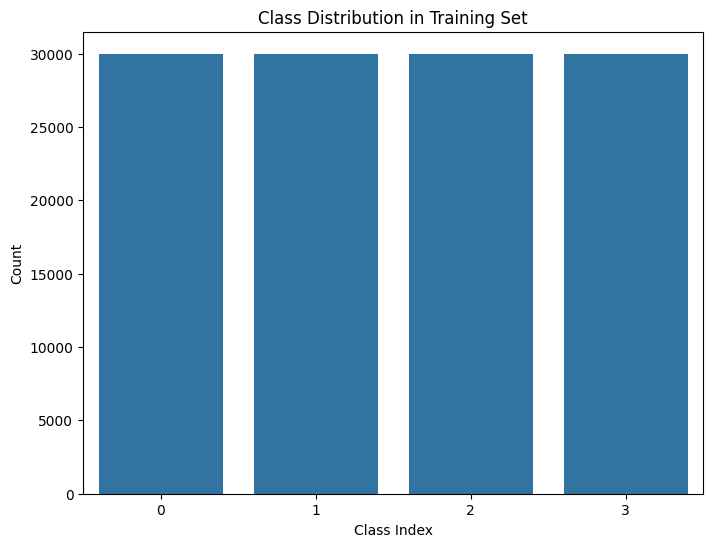


Sample Texts from Each Class:
Class 0 Sample Text:
Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.

Class 1 Sample Text:
Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final. Phelps' rivals Ian Thorpe and Pieter van den Hoogenband and teammate Klete Keller were faster than the teenager in the 200 free preliminaries.

Class 2 Sample Text:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Class 3 Sample Text:
'Madden,' 'ESPN' Football Score in Different Ways (Reu

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.show()

# b. Sample Texts
print("\nSample Texts from Each Class:")
for class_index in sorted(train_df['label'].unique()):
    sample_text = train_df[train_df['label'] == class_index]['text'].values[0]
    print(f"Class {class_index} Sample Text:\n{sample_text}\n")

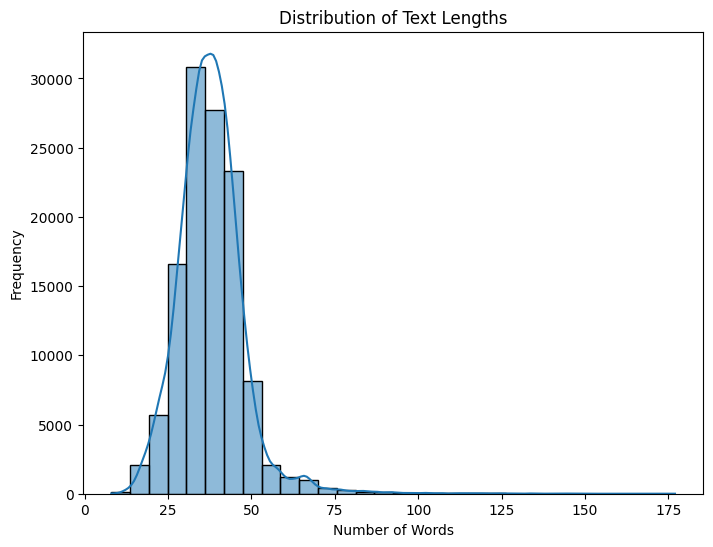

In [5]:
train_df['Text Length'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(train_df['Text Length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# 3. Data Preprocessing and Augmentation
# a. Preprocessing Function
def preprocess_text(text):
    return text.lower().strip()

# b. Apply Preprocessing
train_df["text"] = train_df["text"].apply(preprocess_text)
test_df["text"] = test_df["text"].apply(preprocess_text)

In [7]:
# Data Augmentation Functions
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lem in syn.lemmas():
            synonym = lem.name().replace('_', ' ').lower()
            if synonym != word.lower():
                synonyms.add(synonym)
    return list(synonyms)

from nltk.tokenize import regexp_tokenize

def synonym_replacement(text, n=1):
    words = regexp_tokenize(text, pattern='\w+')
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalpha()]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

def augment_text(text):
    augmented_text = synonym_replacement(text, n=2)
    return augmented_text

# Continue with the rest of your code...

# d. Apply Data Augmentation to Training Data
augmented_texts = []
augmented_labels = []

for index, row in train_df.iterrows():
    augmented_text = augment_text(row['text'])
    augmented_texts.append(augmented_text)
    augmented_labels.append(row['label'])

# Create a new DataFrame with augmented data
augmented_df = pd.DataFrame({
    'label': augmented_labels,
    'text': augmented_texts
})

# Combine with original training data
train_df_augmented = pd.concat([train_df, augmented_df], ignore_index=True)
print("Augmented Training Data Shape:", train_df_augmented.shape)


<>:14: SyntaxWarning: invalid escape sequence '\w'
<>:14: SyntaxWarning: invalid escape sequence '\w'
C:\Users\dhawal bansal\AppData\Local\Temp\ipykernel_15036\3161449959.py:14: SyntaxWarning: invalid escape sequence '\w'
  words = regexp_tokenize(text, pattern='\w+')


Augmented Training Data Shape: (240000, 3)


In [8]:
MODEL_NAME = "google/bert_uncased_L-2_H-128_A-2"  # BERT-Tiny
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# b. Encode Labels (labels are already 0-based)
train_df_augmented['label'] = train_df_augmented['label'].astype(int)
test_df['label'] = test_df['label'].astype(int)

# c. Split Training Data into Training and Validation Sets
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df_augmented["text"].tolist(),
    train_df_augmented["label"].values,
    test_size=0.1,
    random_state=seed
)

# d. Create Dataset Class
class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# e. Create Dataset Instances
train_dataset = AGNewsDataset(train_texts, train_labels, tokenizer)
val_dataset = AGNewsDataset(val_texts, val_labels, tokenizer)
test_dataset = AGNewsDataset(test_df["text"].tolist(), test_df["label"].values, tokenizer)

# f. Create Dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Model Setup
# a. Load Pre-trained Model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)
model.to(device)

# b. Initialize Classification Head Only
if hasattr(model, 'classifier'):  # For models like BERT
    nn.init.xavier_uniform_(model.classifier.weight)
    if model.classifier.bias is not None:
        nn.init.zeros_(model.classifier.bias)
elif hasattr(model, 'bert'):
    nn.init.xavier_uniform_(model.bert.pooler.dense.weight)
    if model.bert.pooler.dense.bias is not None:
        nn.init.zeros_(model.bert.pooler.dense.bias)

# 6. Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

epochs = 5
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
)

config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

c:\Users\dhawal bansal\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dhawal bansal\.cache\huggingface\hub\models--google--bert_uncased_L-2_H-128_A-2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def augment_batch(batch):
    augmented_texts = []
    input_ids = batch['input_ids'].detach().cpu().numpy()
    for ids in input_ids:
        text = tokenizer.decode(ids, skip_special_tokens=True)
        augmented_text = augment_text(text)
        augmented_texts.append(augmented_text)
    encoding = tokenizer(
        augmented_texts,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )
    encoding = {k: v.to(device) for k, v in encoding.items()}
    return encoding

# b. Modified Training Loop with ReFixMatch
def train_refixmatch(model, train_loader, unlabeled_loader, val_loader, criterion, optimizer, scheduler, epochs=5, threshold=0.95, lambda_u=1.0):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_unsup_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)
            
            # Supervised loss
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        
        # Unsupervised training with unlabeled data
        for batch in unlabeled_loader:
            model.train()
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            outputs = model(**inputs)
            logits = outputs.logits.detach()
            probs = torch.softmax(logits, dim=-1)
            max_probs, pseudo_labels = torch.max(probs, dim=-1)
            mask = max_probs > threshold
            
            if mask.sum() > 0:
                # Augment inputs
                augmented_inputs = augment_batch(batch)
                augmented_outputs = model(**augmented_inputs)
                unsupervised_loss = criterion(augmented_outputs.logits[mask], pseudo_labels[mask])
                unsupervised_loss = lambda_u * unsupervised_loss
                unsupervised_loss.backward()
                optimizer.step()
                scheduler.step()
                total_unsup_loss += unsupervised_loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        avg_unsup_loss = total_unsup_loss / len(unlabeled_loader) if len(unlabeled_loader) > 0 else 0
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
                labels = batch["labels"].to(device)
                outputs = model(**inputs)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Unsupervised Loss: {avg_unsup_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model1.pth')
    
    return train_losses, val_losses


Epoch 1/5, Train Loss: 0.2899, Unsupervised Loss: 0.0268, Val Loss: 0.2520
Epoch 2/5, Train Loss: 0.1965, Unsupervised Loss: 0.0197, Val Loss: 0.2051
Epoch 3/5, Train Loss: 0.1525, Unsupervised Loss: 0.0246, Val Loss: 0.1839
Epoch 4/5, Train Loss: 0.1278, Unsupervised Loss: 0.0328, Val Loss: 0.1616
Epoch 5/5, Train Loss: 0.1143, Unsupervised Loss: 0.0302, Val Loss: 0.1492


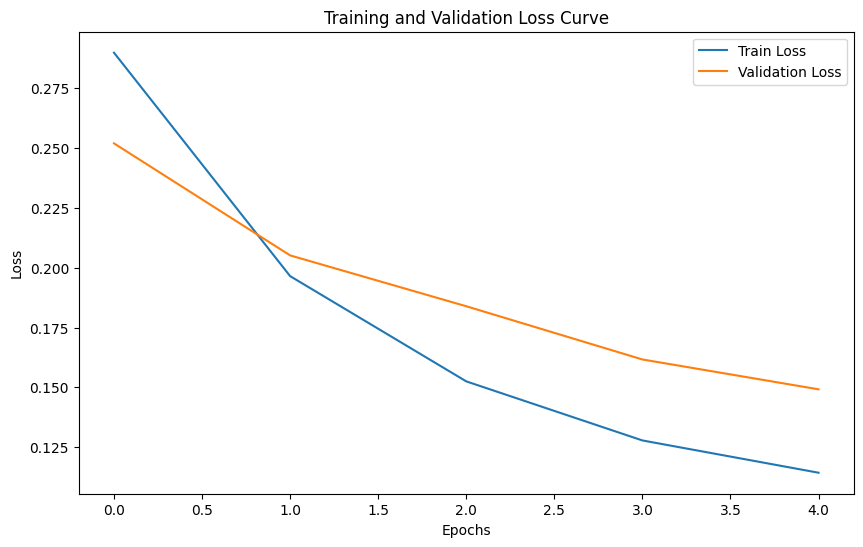

In [12]:
unlabeled_texts = test_df["text"].tolist()

# Create dataset with dummy labels (labels won't be used)
unlabeled_labels = [-1] * len(unlabeled_texts)
unlabeled_dataset = AGNewsDataset(unlabeled_texts, unlabeled_labels, tokenizer)

unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

# 8. Training the Model
lambda_u = 1.0  # Weight for unsupervised loss
threshold = 0.95

train_losses, val_losses = train_refixmatch(
    model, train_loader, unlabeled_loader, val_loader,
    criterion, optimizer, scheduler, epochs, threshold, lambda_u
)

# 9. Plot Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

C:\Users\dhawal bansal\AppData\Local\Temp\ipykernel_15036\1633983029.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model1.pth'))

Accuracy: 0.9283, Precision: 0.9283, Recall: 0.9283, F1-score: 0.9282

Classification Report:
               precision    recall  f1-score   support

           0     0.9456    0.9326    0.9391      1900
           1     0.9725    0.9853    0.9788      1900
           2     0.9045    0.8826    0.8934      1900
           3     0.8906    0.9126    0.9015      1900

    accuracy                         0.9283      7600
   macro avg     0.9283    0.9283    0.9282      7600
weighted avg     0.9283    0.9283    0.9282      7600



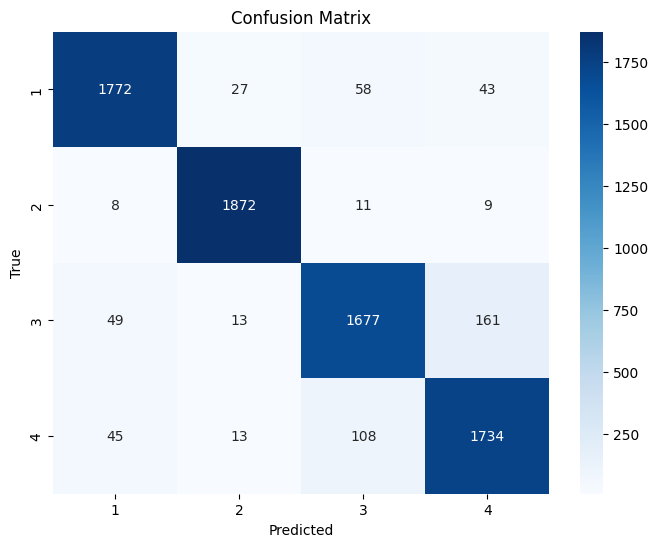

(0.9282894736842106,
 0.9282925431219908,
 0.9282894736842106,
 0.9282022242708821)

In [14]:
model.load_state_dict(torch.load('best_model1.pth'))

# Evaluate Model
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_probs = []
    
    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].cpu().numpy()
            outputs = model(**inputs).logits.cpu()
            predictions = outputs.argmax(dim=1).numpy()
            probabilities = torch.nn.functional.softmax(outputs, dim=1).numpy()
            y_true.extend(labels)
            y_pred.extend(predictions)
            y_probs.extend(probabilities)
    
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return acc, precision, recall, f1

evaluate_model(model, test_loader)

NameError: name 'model' is not defined